In [136]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from scipy.stats import pearsonr
import matplotlib
from tqdm import tqdm
from typing import List, Dict
import calprs

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [137]:
df_trait = pd.read_csv(
    "../compile-data/out/per-trait-info/LDL.tsv.gz", sep="\t", index_col=0
)
df_trait_white = df_trait[df_trait.group == "United Kingdom"].copy()
df_trait_other = df_trait[df_trait.group != "United Kingdom"].copy()

In [138]:
dict_bins = {}
for group in ["white", "other"]:
    df = {"white": df_trait_white, "other": df_trait_other}[group]
    for cov in ["PC1", "AGE", "SEX"]:
        if len(df[cov].dropna().unique()) > 5:
            dict_bins[(group, cov)] = pd.qcut(
                df[cov], q=5, duplicates="drop", retbins=True
            )[1]

In [174]:
data_prefix = "LDL-other"
trait, group = data_prefix.split("-")

In [175]:
cov_list = ["PC1", "AGE", "SEX"]

In [176]:
dict_r2 = dict()
dict_coverage = dict()
for k in [("const", "all"), ("const", "none"), ("mcmc", "all"), ("mcmc", "none")]:
    dict_r2[k] = {cov: [] for cov in cov_list}
    dict_coverage[k] = {cov: [] for cov in cov_list}

for seed in range(1, 11):
    for k in dict_r2:
        predstd, ci_adjust = k
        df_test = pd.read_csv(
            f"out/model/{data_prefix}/{predstd}-{seed}-{ci_adjust}.test_info.tsv",
            sep="\t",
            index_col=0,
        )
        for cov in ["PC1", "AGE", "SEX"]:
            if len(df_test[cov].dropna().unique()) > 5:
                df_test[cov] = pd.cut(
                    df_test[cov], bins=dict_bins[(group, cov)], include_lowest=True
                ).cat.codes
            df_cal = calprs.summarize_pred(
                df_test,
                y_col="pheno",
                pred_col="cal_pred",
                predstd_col="cal_predstd",
                group_col=cov,
            )
            dict_r2[k][cov].append(df_cal["r2"])
            dict_coverage[k][cov].append(df_cal["coverage"])

for k in dict_r2:
    for cov in dict_r2[k]:
        dict_r2[k][cov] = pd.concat(dict_r2[k][cov], axis=1).T.reset_index(drop=True)
        dict_coverage[k][cov] = pd.concat(dict_coverage[k][cov], axis=1).T.reset_index(
            drop=True
        )

In [177]:
def plot_figure(
    dict_r2: Dict,
    dict_cov1: Dict,
    dict_cov2: Dict,
    trait: str,
    xlabels: List,
    xlabel_map: Dict,
    ylim_r2: List = None,
    ylim_cov: List = None,
):
    """
    dict_r2
    """
    width_ratios = [len(dict_r2[x][0]) for x in xlabels]
    fig, axes = plt.subplots(
        figsize=(0.3 * sum(width_ratios) + 0.1 * len(width_ratios), 3.5),
        dpi=150,
        nrows=2,
        ncols=len(xlabels),
        sharex="col",
        sharey="row",
        gridspec_kw={"width_ratios": width_ratios},
    )
    for i, group in enumerate(xlabels):
        ax = axes[0, i]
        df_r2 = dict_r2[group]
        n_group = df_r2.shape[1]
        mean, sd = df_r2.mean(axis=0), df_r2.std(axis=0)
        ax.errorbar(
            x=np.arange(n_group),
            y=mean,
            yerr=sd,
            fmt=".--",
            ms=4,
            mew=1,
            linewidth=1,
            color="black",
        )
        ax.set_xlim(-0.5, n_group - 0.5)
        if ylim_r2 is not None:
            ax.set_ylim(*ylim_r2)
        if i == 0:
            ax.set_ylabel(f"{trait} $R^2$")

    # coverage
    for i, group in enumerate(xlabels):
        ax = axes[1, i]

        ax.axhline(y=0.9, ls="--", lw=1.0, color="black", alpha=0.5)
        if ylim_cov is not None:
            ax.set_ylim(*ylim_cov)
        if i == 0:
            ax.set_ylabel(f"{trait} coverage")

        for cov_i, dict_cov in enumerate([dict_cov1, dict_cov2]):
            cov_vals = dict_cov[group].values
            cov_mean, cov_sd = cov_vals.mean(axis=0), cov_vals.std(axis=0)
            n_group = cov_vals.shape[1]
            label = ["Overall", "By-cov"][cov_i]
            ax.errorbar(
                x=np.arange(n_group) - 0.1 + cov_i * 0.2,
                y=cov_mean,
                yerr=cov_sd,
                fmt=".--",
                ms=4,
                mew=1,
                linewidth=0.8,
                label=label,
            )
        ax.set_xticks(np.arange(n_group))
        ax.set_xlabel(xlabel_map[group])

    return fig, axes

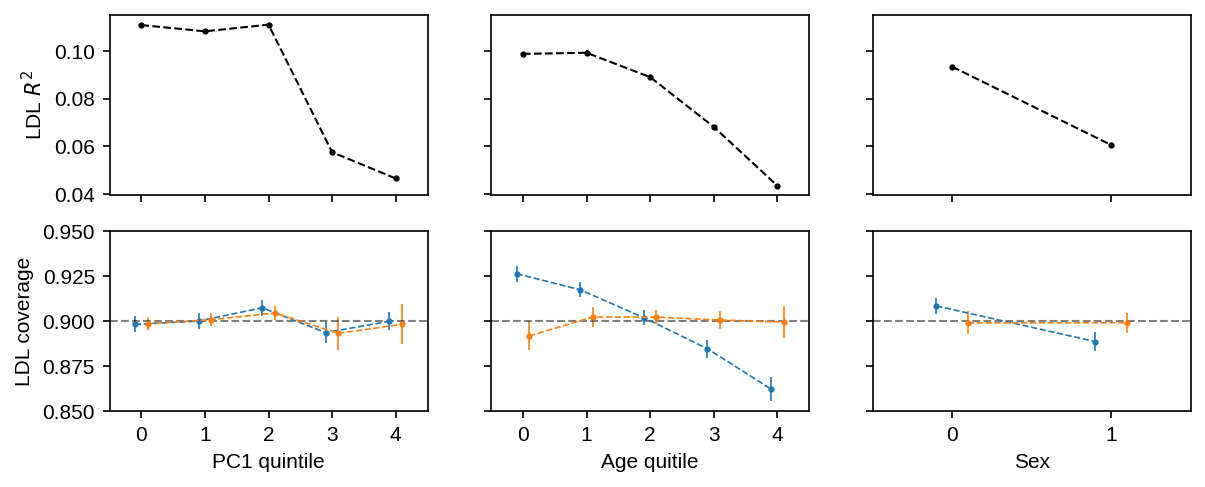

In [180]:
fig, axes = plot_figure(
    dict_r2["const", "none"],
    dict_coverage["const", "none"],
    dict_coverage["const", "all"],
    xlabels=["PC1", "AGE", "SEX"],
    xlabel_map={"PC1": "PC1 quintile", "AGE": "Age quitile", "SEX": "Sex"},
    trait="LDL",
    ylim_cov=[0.85, 0.95],
    #     ylim_r2=[0.04, 0.21],
)